<a href="https://colab.research.google.com/github/caroAM22/Trabajo_VA/blob/main/Trabajo_vision_artificial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<h1><center>Trabajo Visión Artificial </center></h1>**

**<h1><center> 2023-2s </center></h1>**
---


---


# Programa para detectar la calidad de los neumáticos

---


## Integrantes:

*   **Carolina Alvarez Murillo**  Ingeniería de sistemas e informática
*   **Mateo Alvarez Murillo**  Ingeniería de sistemas e informática
*   **Cristian Londoño Franco**  Ingeniería de sistemas e informática
*   **Miguel Angel Martinez Arenas**  Ingeniería física



# DATASET

Desarrollaremos el programa para el reconocimiento de neumáticos defectuosos con el dataset [Tyre Quality Classification](https://www.kaggle.com/datasets/warcoder/tyre-quality-classification) obtenido de [Kaggle](https://www.kaggle.com/) el cual está compuesto de 1854 imágenes digitales en formato jpg, en cada una se visualiza un solo neumático o partes de uno. Están etiquetadas, según su estado, 1028 imágenes clasificadas como defectuosas y 828 como buenas. El objetivo del conjunto de datos es facilitar el desarrollo de sistemas de inspección más precisos y eficientes para la producción de neumáticos.

# Objetivo

Mejorar el proceso de control de calidad de la industria de neumáticos y reducir las posibilidades de accidentes debido a neumáticos defectuosos.

# Metodología

En el proceso de análisis de un dataset de imágenes de llantas defectuosas y en buen estado, se realizaron las siguientes etapas:

* Lectura y carga de las imágenes.
* Redimensionamiento a un tamaño uniforme.
* Prueba de diferentes espacios y canales de color.

## Librerías

In [32]:
#Importamos las librerías que vamos a utilizar

import os
import pandas as pd
import numpy as np
import cv2
from google.colab import drive
import matplotlib.pyplot as plt
import random
from IPython.utils.text import num_ini_spaces

## Lectura de imagenes desde drive

In [3]:
#Obtenemos el conjunto de datos desde nuestras cuentas de drive, donde previamente descargamos el dataset.

drive.mount("/content/drive")
path_defective = "/content/drive/Shareddrives/Visión artificial/Dataset/defective"
path_good = "/content/drive/Shareddrives/Visión artificial/Dataset/good"

Mounted at /content/drive


## Funciones

### Función para mostrar algunas imagenes

In [5]:
# Función para mostrar algunas imagenes del dataset

def show_images(n, m, images, title):
  fig, ax = plt.subplots(3,3, figsize = (15,12))
  im = 0
  fig.suptitle(title, fontsize=40)

  for i in range (0,n):
    for j in range (0,m):
      img_rgb = cv2.cvtColor(images[j+im], cv2.COLOR_BGR2RGB)
      ax[i,j].imshow(img_rgb)
      ax[i,j].set_axis_off()
    im += 5

### Función para aplicar diferentes canales de color

In [22]:
#Leemos una imagen del conjunto defectuoso y aplicamos los canales de color

def canales_color(images):
    img_rgb = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(4,3, figsize = (20,20))

    ax[0,0].imshow(img_rgb[:,:,0],cmap="gray")
    ax[0,0].set_title("Canal R")
    ax[0,1].imshow(img_rgb[:,:,1],cmap="gray")
    ax[0,1].set_title("Canal G")
    ax[0,2].imshow(img_rgb[:,:,2],cmap="gray")
    ax[0,2].set_title("Canal B")

    #Canal HSV
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    ax[1,0].imshow(img_hsv[:,:,0],cmap="gray")
    ax[1,0].set_title("Canal H")
    ax[1,1].imshow(img_hsv[:,:,1],cmap="gray")
    ax[1,1].set_title("Canal S")
    ax[1,2].imshow(img_hsv[:,:,2],cmap="gray")
    ax[1,2].set_title("Canal V")

    #Canal LAB
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    ax[2,0].imshow(img_lab[:,:,0],cmap="gray")
    ax[2,0].set_title("Canal L")
    ax[2,1].imshow(img_lab[:,:,1],cmap="gray")
    ax[2,1].set_title("Canal A")
    ax[2,2].imshow(img_lab[:,:,2],cmap="gray")
    ax[2,2].set_title("Canal B")

    #Canal YUV
    img_yuv  = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

    ax[3,0].imshow(img_yuv[:,:,0],cmap="gray")
    ax[3,0].set_title("Canal Y")
    ax[3,1].imshow(img_yuv[:,:,1],cmap="gray")
    ax[3,1].set_title("Canal U")
    ax[3,2].imshow(img_yuv[:,:,2],cmap="gray")
    ax[3,2].set_title("Canal V")

    plt.show()

### Funciones de trasnformación lineal

In [27]:
def apply_f_on_rgb(img, f, args):
    #Crear una matriz de ceros del tamaño de la imagen de entrada
    res = np.zeros(img.shape, np.uint8)
    #Aplicar la transformación f sobre cada canal del espacio de color RGB
    res[:,:,0] = f(img[:,:,0], *args)
    res[:,:,1] = f(img[:,:,1], *args)
    res[:,:,2] = f(img[:,:,2], *args)

    return res

#Definir la función corrección gamma
def gamma_correction(img, a, gamma):
    #Crear copia de la imagen tipo flotante dada la normalización
    img_copy = img.copy().astype(np.float32)/255.0
    #La función corrección gamma es de la forma ax^gamma, donde x es la imagen de entrada
    res_gamma = cv2.pow(img_copy,gamma)
    res = cv2.multiply(res_gamma, a)

    #Asegurar que la los datos queden entre 0 y 255 y sean uint8
    res[res<0] = 0
    res = res*255.0
    res[res>255] = 255

    res = res.astype(np.uint8)

    return res

#Definir la función expansión
def histogram_expansion(img):

    #Crear matriz de ceros del tamaño de la imagen y tipo de dato flotante
    res = np.zeros([img.shape[0], img.shape[1]], dtype=np.float32)

    #Extraer el mínimo y el máximo del conjunto de datos
    m = float(np.min(img))
    M = float(np.max(img))
    #Aplicar la función de expansión(normalización) y asegurar datos uint8
    res = (img-m)*255.0/(M-m)
    res = res.astype(np.uint8)

    return res

def graficar(img, leg, his, a, b):
    #Generar un subplot 2x2 para contrastar imágen original con transformada y sus histogramas
    fig, arreglo_plots = plt.subplots(len(img),2, figsize=(a, b))
    colors = ('r','g','b')

    for i in range(len(img)):
        arreglo_plots[i,0].set_title(leg[i])
        arreglo_plots[i,0].imshow(img[i], cmap="gray")
        arreglo_plots[i,1].set_title(his[i])
        for j,col in enumerate(colors):
            img_array_i = img[i][:,:,j].ravel()
            arreglo_plots[i,1].hist(img_array_i,histtype='step', bins=255,
                                    range=(0.0, 255.0),density=True, color=colors[j])


### Funciones de analisis

In [36]:
def generar_img_aleatorias():
    img_aleatorias = []
    for _ in range(3):
        numero = random.randint(1, 801)
        img_aleatorias.append(numero)
    return img_aleatorias

a1, b1, c1 = generar_img_aleatorias()
print(a1, b1, c1)

458 758 242


In [39]:
def calcular_luminancia_promedio(lista_de_imagenes):
    luminancias_promedio = []

    for imagen in lista_de_imagenes:
        # Convierte la imagen a escala de grises si no lo está
        if len(imagen.shape) == 3:
            imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_RGB2GRAY)
        else:
            imagen_gris = imagen

        # Calcula la luminancia promedio de la imagen y la agrega a la lista
        luminancia_promedio = np.mean(imagen_gris)
        print(np.mean(imagen_gris))
        luminancias_promedio.append(luminancia_promedio)

    # Calcula el promedio de las luminancias promedio de todas las imágenes
    luminancia_promedio_total = np.mean(luminancias_promedio)

    return luminancia_promedio_total

In [33]:
def separar_imagenes_brillantes_oscuras(imagenes, umbral):
    imagenes_brillantes = []
    imagenes_oscuras = []

    for imagen in imagenes:
        # Convierte la imagen a escala de grises si no lo está
        if len(imagen.shape) == 3:
            imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_RGB2GRAY)
        else:
            imagen_gris = imagen

        # Calcula la luminancia promedio de la imagen
        luminancia_promedio = imagen_gris.mean()

        # Clasifica la imagen en base al umbral
        if luminancia_promedio >= umbral:
            imagenes_brillantes.append(imagen)
        else:
            imagenes_oscuras.append(imagen)

    return imagenes_brillantes, imagenes_oscuras

## Lectura de imágenes y estandarización del tamaño

In [4]:
# Función para leer y redimensionar el tamaño de las imagenes

def read_and_resize_images(folder, new_width, new_height):
    #Creamos una lista para almacenar las imagenes
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            #Se lee la imagen de la ruta
            image = cv2.imread(os.path.join(folder, filename))
            if image is not None:
                #Se redimensiona y se guarda en la lista
                resized_image = cv2.resize(image, (new_width, new_height))
                images.append(resized_image)
    return images

#Establecemos un tamaño de ancho y largo para las imagenes
new_width = 1280
new_height = 720

#Llamamos la función para ambos conjuntos de datos
defective_images = read_and_resize_images(path_defective, new_width, new_height)
good_images = read_and_resize_images(path_good, new_width, new_height)

## Visualización de las imagenes

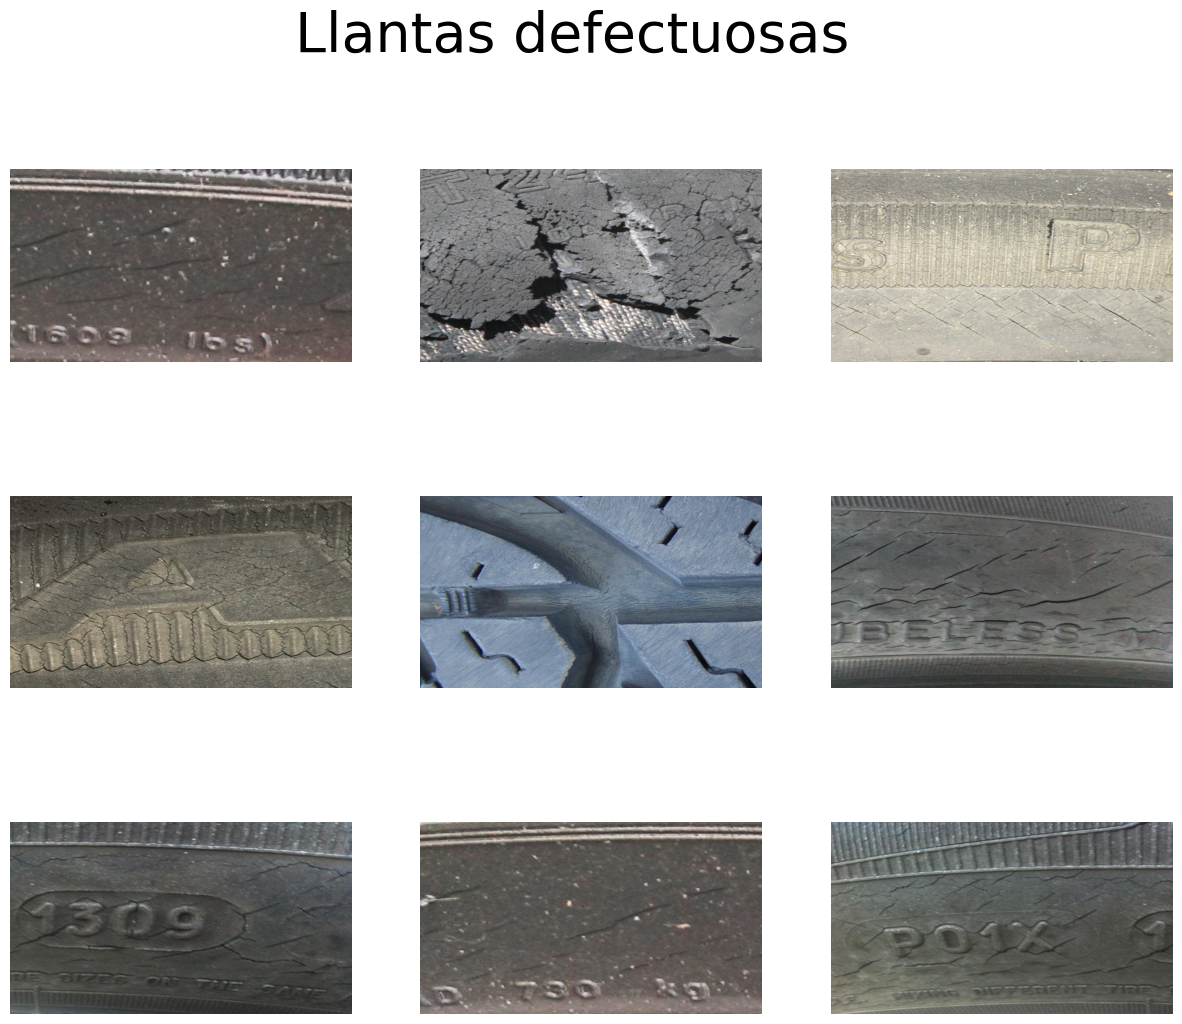

In [7]:
# Visualizacion de llantas defectuosas
show_images(3,3, defective_images, 'Llantas defectuosas')

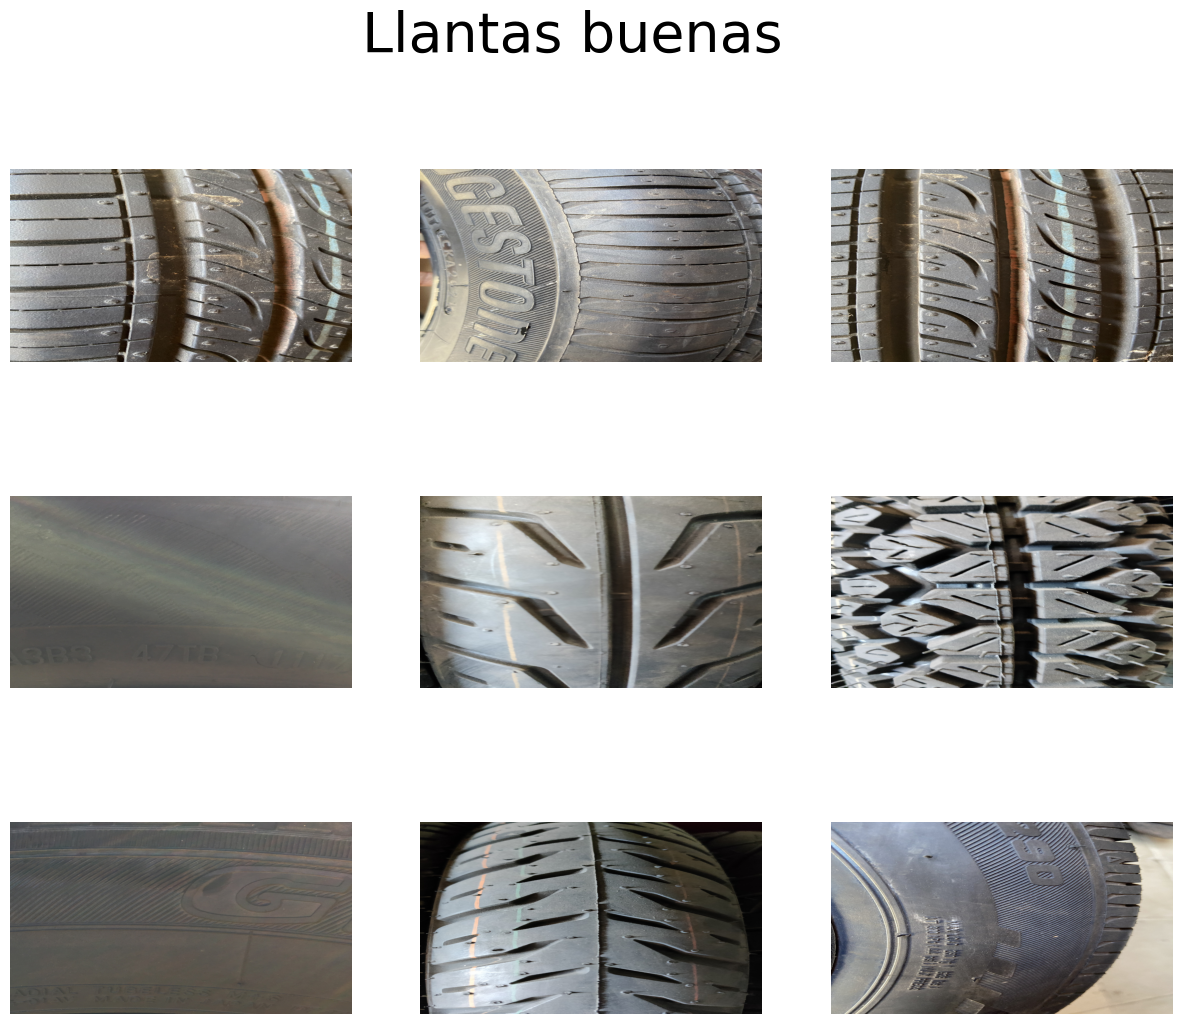

In [8]:
# Visualizacion de llantas buenas
show_images(3,3, good_images, 'Llantas buenas')

## Análisis del canal

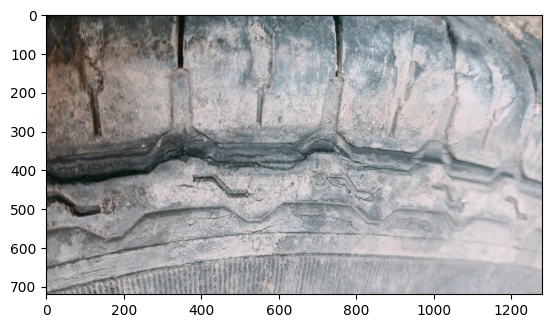

In [21]:
img = cv2.cvtColor(defective_images[806], cv2.COLOR_BGR2RGB)
plt.imshow(img)


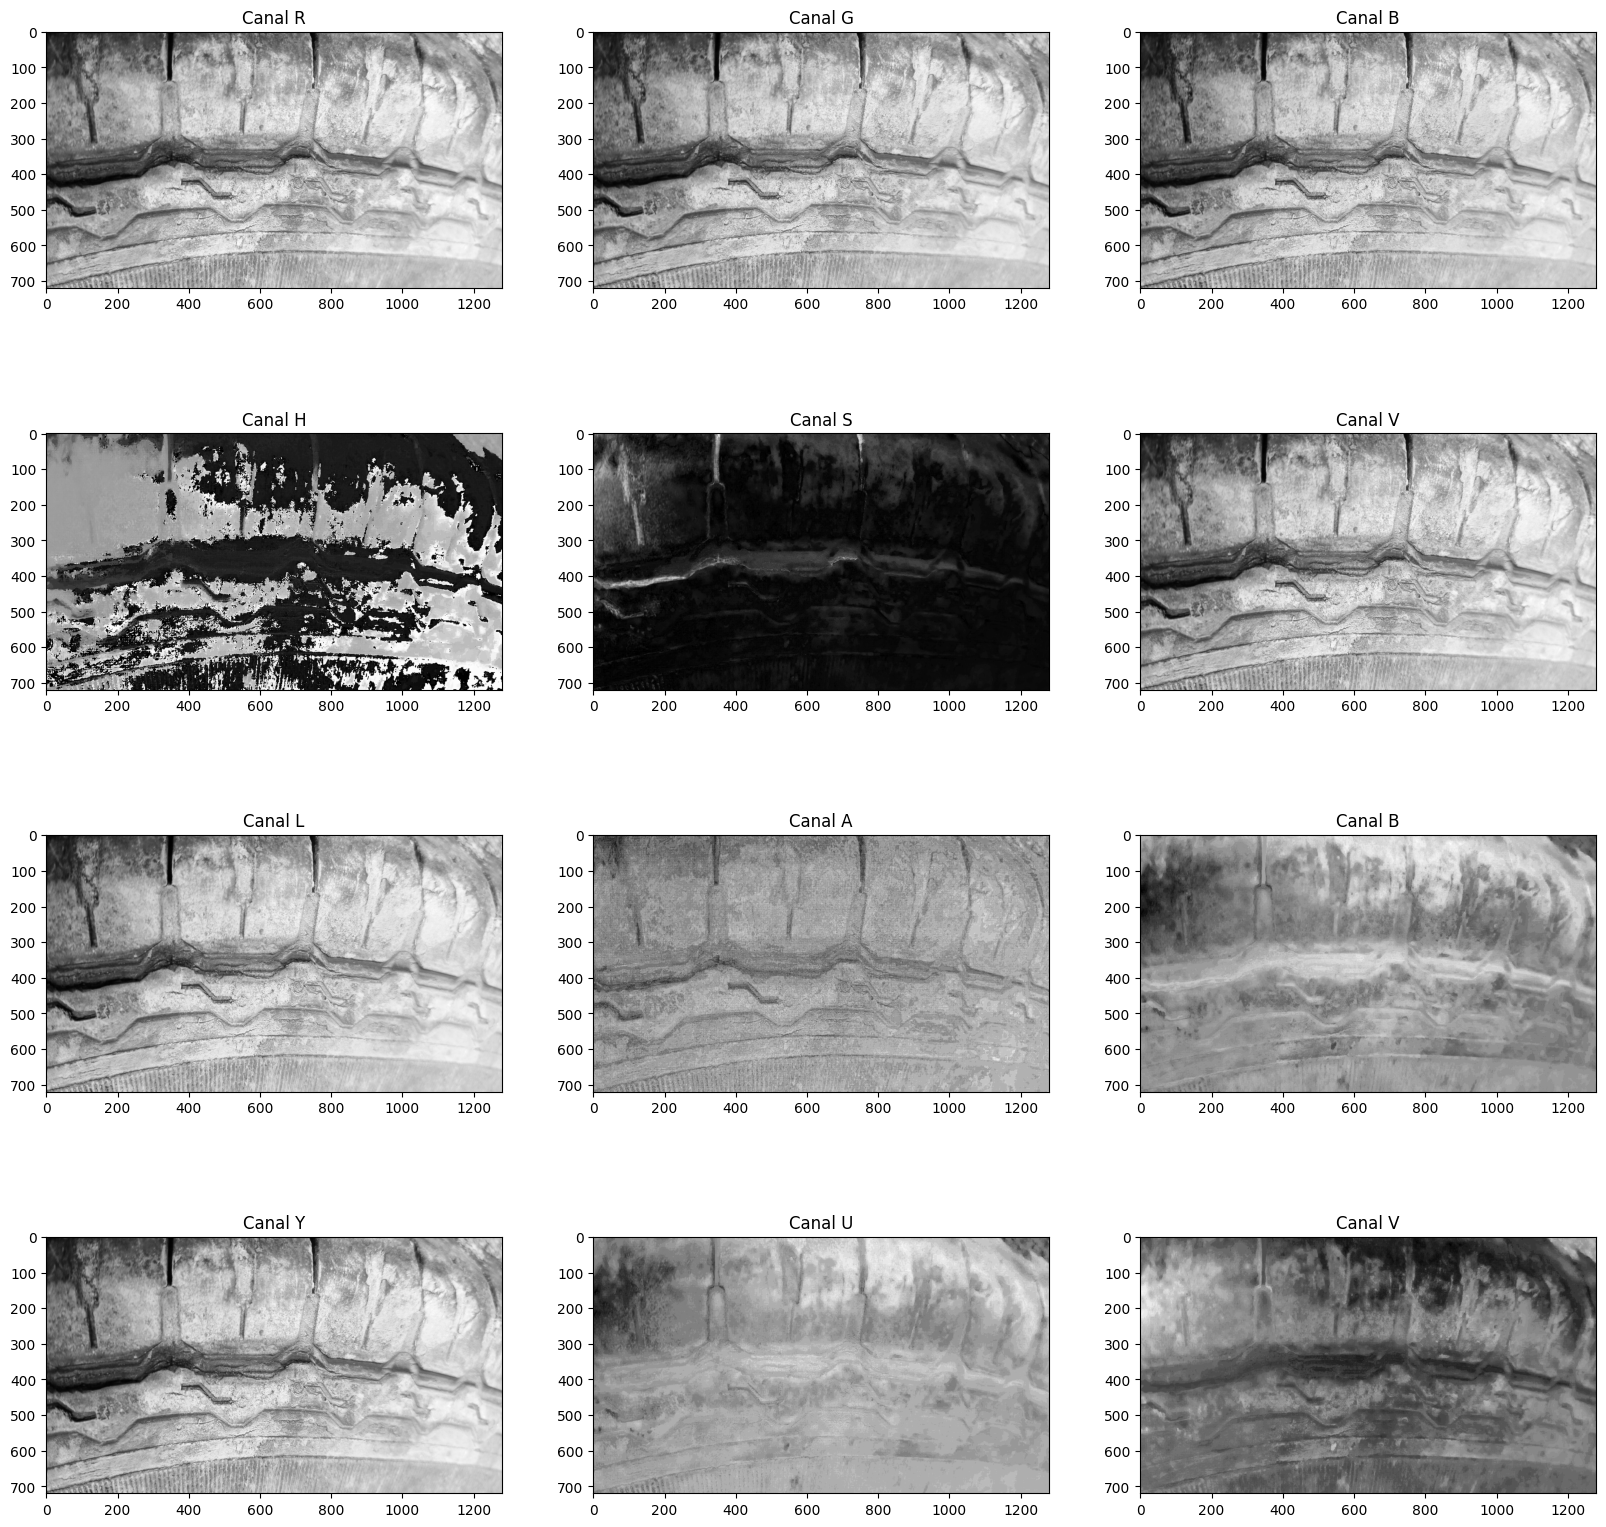

In [23]:
canales_color(defective_images[806])

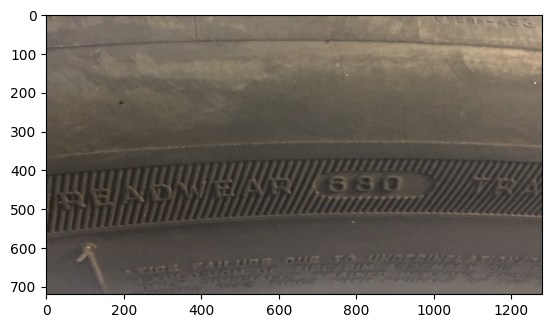

In [24]:
img = cv2.cvtColor(good_images[806], cv2.COLOR_BGR2RGB)
plt.imshow(img)

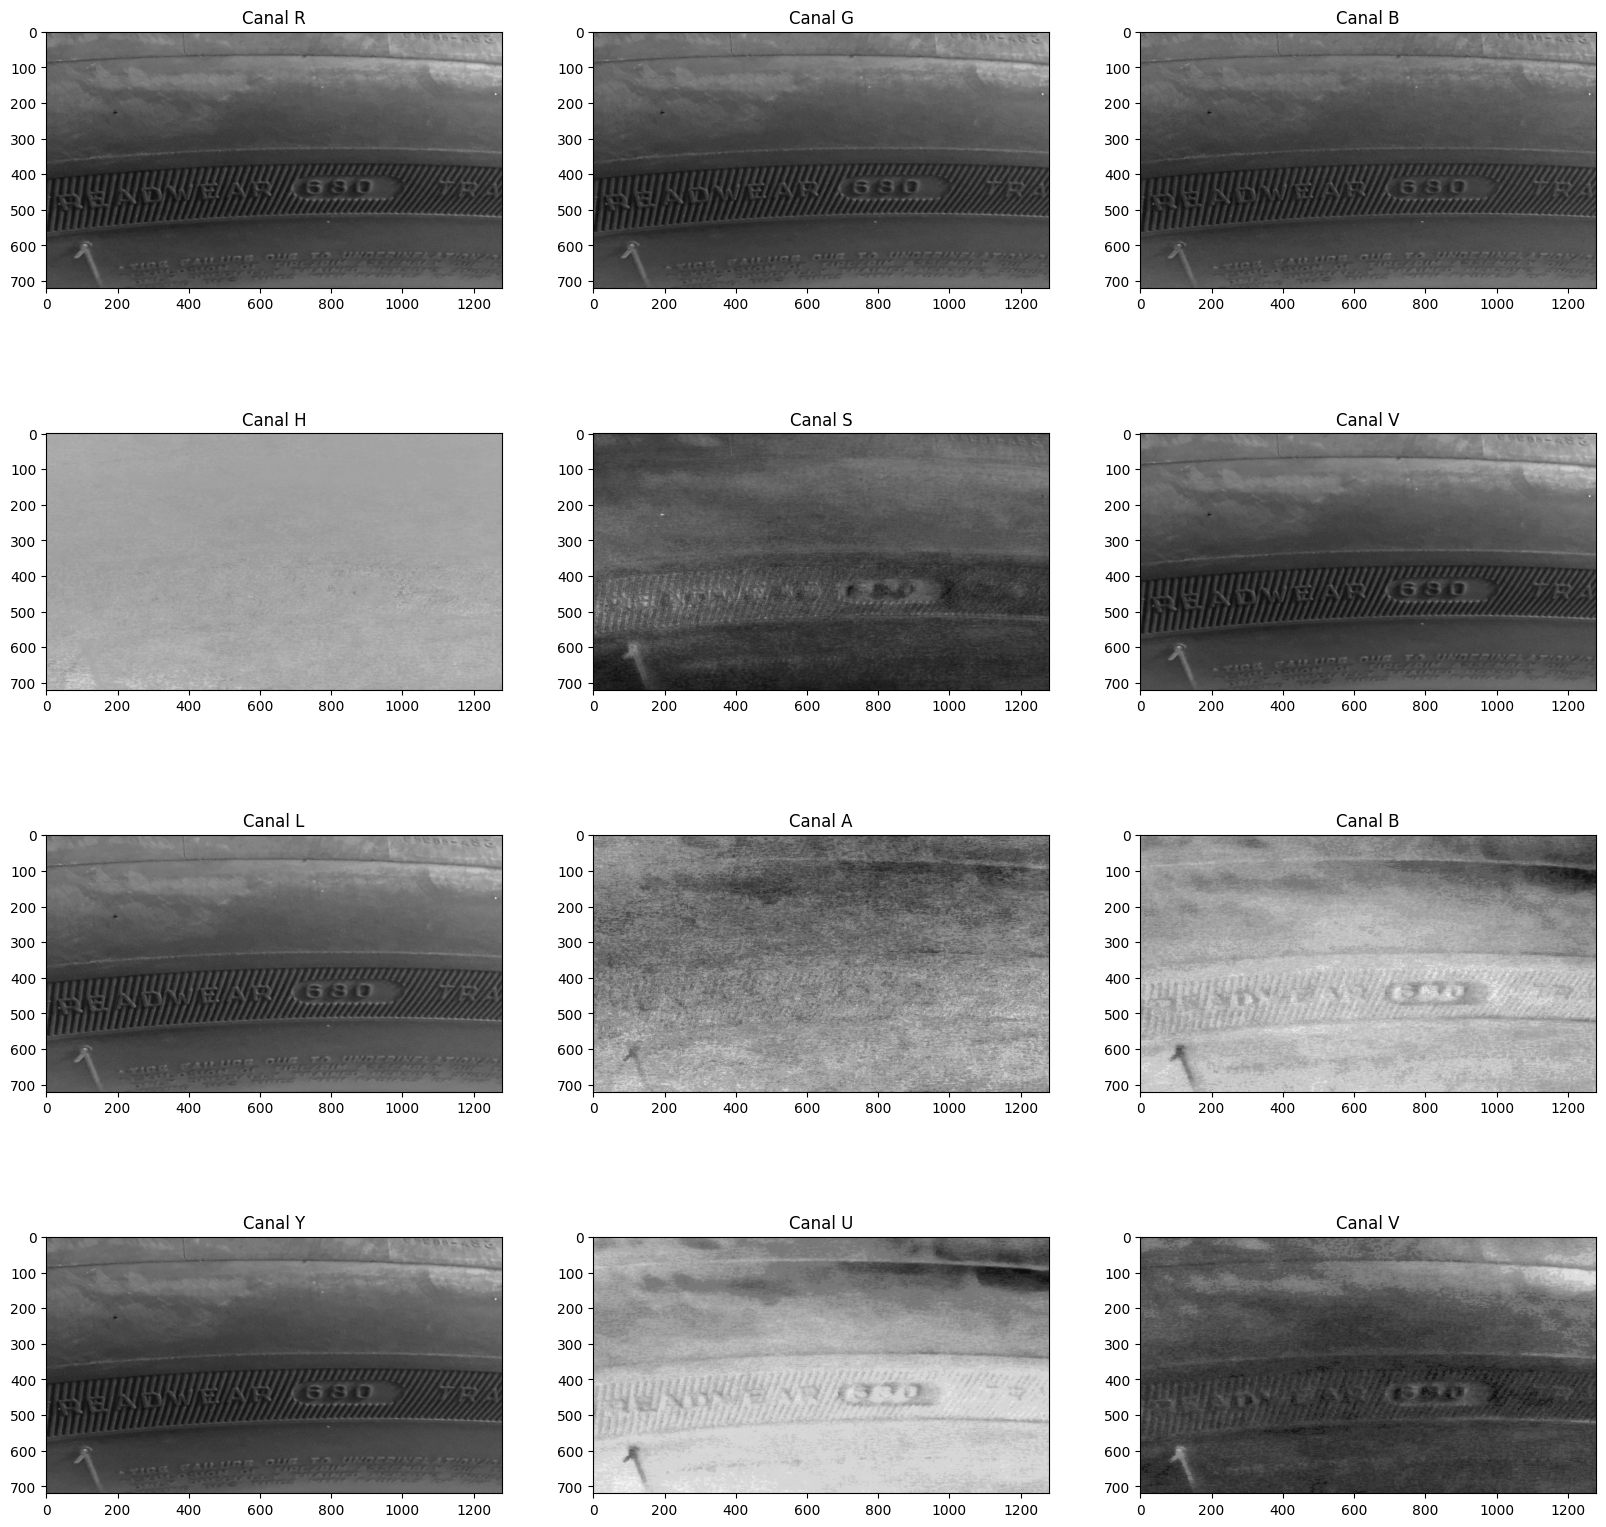

In [25]:
canales_color(good_images[806])

## Análisis transformaciones lineales

In [40]:
img=[good_images[a1], good_images[b1], good_images[c1], defective_images[a1],  defective_images[b1], defective_images[c1]]
umbral = calcular_luminancia_promedio(img)
umbral

147.50794379340277
97.93194769965278
129.219169921875
123.83071614583334
118.27573350694445
103.62448459201389


120.06499927662037

In [ ]:
# Llamar a la función para separar las imágenes
img_b, img_o = separar_imagenes_brillantes_oscuras(img, umbral)

# Crear una figura con dos columnas
fig, axs = plt.subplots(len(img_b), 2, figsize=(12, 12))

# Título para las dos columnas
axs[0, 0].set_title('Imágenes Brillantes')
axs[0, 1].set_title('Imágenes Oscuras')

# Mostrar las imágenes brillantes en la primera columna
for i, img_b in enumerate(img_b):
    axs[i, 0].imshow(cv2.cvtColor(img_b, cv2.COLOR_RGB2BGR))
    axs[i, 0].axis('off')

# Mostrar las imágenes oscuras en la segunda columna
for i, img_o in enumerate(img_o):
    axs[i, 1].imshow(cv2.cvtColor(img_o, cv2.COLOR_RGB2BGR))
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

KeyboardInterrupt: ignored

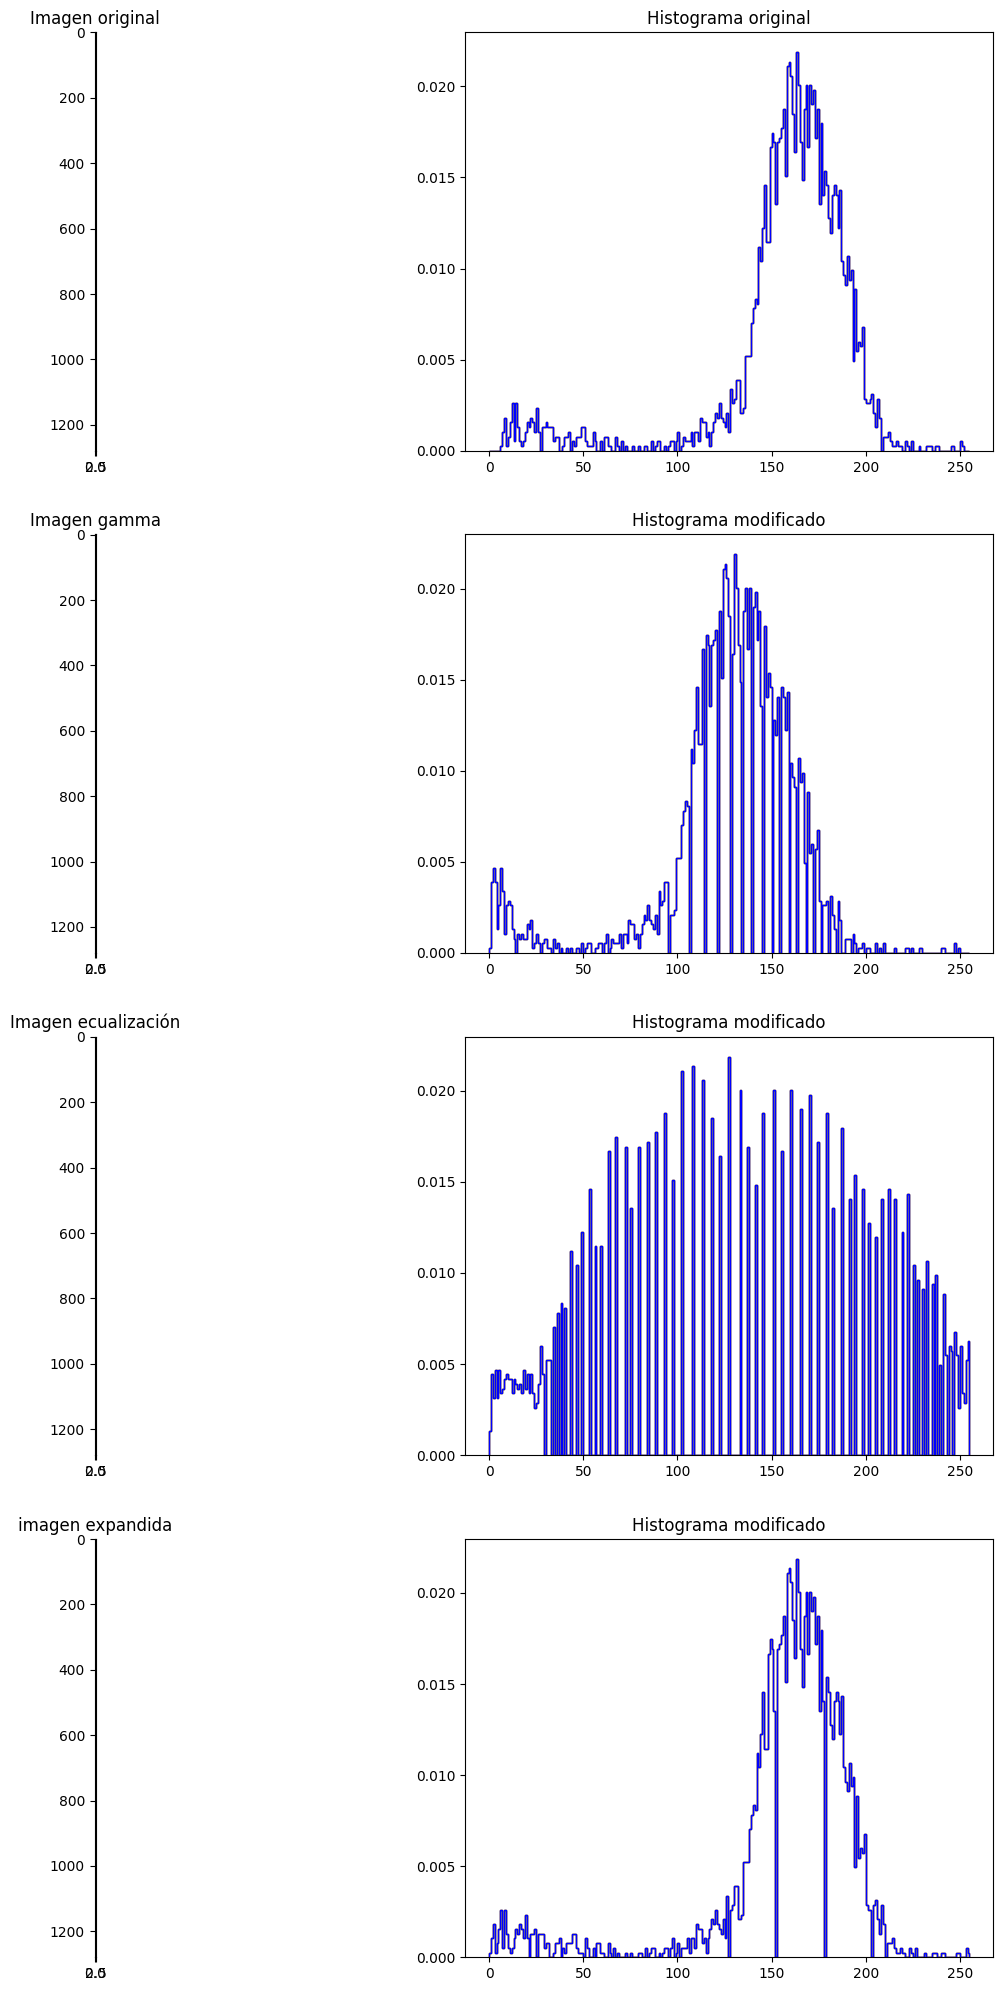

In [49]:
img=cv2.cvtColor(good_images[3], cv2.COLOR_RGB2BGR)
#Aplicar la transformación corrección gamma sobre la imagen de entrada
imagen_gamma = apply_f_on_rgb(img, gamma_correction, [1, 1.5])

#Aplicar la transformación de ecualización de cv2 a la imagen de entrada
imagen_ecualizacion = apply_f_on_rgb(img, cv2.equalizeHist, [])

#Aplicar la transformación expansión de histograma sobre la imagen de entrada
imagen_expandida = apply_f_on_rgb(img, histogram_expansion, [])

graficar([img, imagen_gamma, imagen_ecualizacion, imagen_expandida],["Imagen original","Imagen gamma","Imagen ecualización","imagen expandida"],["Histograma original","Histograma modificado","Histograma modificado","Histograma modificado"],15,25)

# Conclusiones

En el proceso de análisis de llantas defectuosas, se llevaron a cabo varias etapas clave:

1. **Lectura y carga de imágenes:** En primer lugar, se procedió a cargar todas las imágenes del dataset. Este paso es fundamental para poder trabajar con las imágenes en un entorno de programación.

2. **Redimensionamiento de imágenes:** Para garantizar la uniformidad en el procesamiento, todas las imágenes se redimensionaron a un tamaño estándar. Esto es importante para que todas las imágenes tengan las mismas dimensiones, lo que facilita su manipulación y análisis.

3. **Exploración de espacios de color:** Se realizaron pruebas utilizando diferentes espacios de color, como HSV, YUV y LAB, para analizar cómo afectaban la representación de las imágenes. Sin embargo, se observó que estos espacios de color a veces distorsionaban la imagen o no resaltaban adecuadamente las áreas de interés, como las grietas o el desgaste de las llantas.

4. **Selección del espacio de color RGB:** Tras realizar pruebas exhaustivas, se determinó que el espacio de color RGB era el más adecuado en términos de conservar la integridad de la imagen y proporcionar una representación visual precisa de las llantas.

5. **Elección del canal de color gris:** Para resaltar eficazmente las grietas y el desgaste en las llantas, se optó por seleccionar el canal de color gris (escala de grises) como la representación de color final. Esto permite una visualización más clara de los detalles, lo que facilita la detección de posibles defectos.

En resumen, el proceso de análisis de imágenes de llantas defectuosas y en buen estado involucró la lectura y redimensionamiento de las imágenes, seguido de una selección cuidadosa del espacio de color RGB y el canal de color gris. Esta elección final proporciona una representación efectiva para identificar y evaluar las grietas y el desgaste en las llantas del dataset.

# Referencias

* https://www.kaggle.com/datasets/warcoder/tyre-quality-classification